# Dive into Abusive Language with Snorkel

Author: BingYune Chen 
<br>
Updated: 2021-08-02

----------

### Labeling Functions

Snorkel is an approach for using weak supervision to train multi-task models. Weakly-supervised tasks are created by users in the form of labeling functions, which are then applied over unlabeled data. The outputs of labeling functions can be executed in Snorkel to train auto-compiled multi-task learning networks.

**Key Advantages of Weak Supervision in Multi-Task Learning:**

* Classifier can be updated by simply updating the labeling functions to rebuild training set
* Discriminative models are better able to generalize beyond the arbitrarily many weakly-supervised tasks, leading to an improvement in recall

**We will first build a few trained classifers to use as labeling functions.**

In [ ]:
# Imports and setup for Google Colab

# Mount Google Drive
from google.colab import drive ## module to use Google Drive with Python
drive.mount('/content/drive') ## mount to access contents

In [ ]:
# Imports for data and plotting
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline 
import seaborn as sns

import pickle
import os

In [ ]:
# Imports for data augmentation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import spacy
spacy.prefer_gpu()
from spacy.tokenizer import _get_regex_pattern

import collections
import random
import re

import operator

import math
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [ ]:
# Imports for bag-of-words
from sklearn import feature_extraction, feature_selection, model_selection
from sklearn import naive_bayes, pipeline, metrics, manifold, preprocessing

In [ ]:
# Imports for word embedding
import gensim
from gensim.models.phrases import Phrases, Phraser

# Imports for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing

In [ ]:
# Load labeled dataset for training 
df_train = pd.read_pickle('../data/processed/df_train.pkl')
df_train.reset_index(drop=True, inplace=True)

df_dev = pd.read_pickle('../data/processed/df_dev.pkl')
df_dev.reset_index(drop=True, inplace=True)

df_train.head()

,label,tweet
0,1,#has_mention ee you got the hoes
1,1,Most of you hoes copy and paste but there has ...
2,1,#has_mention only when ur around me 😋 got to k...
3,1,"#has_retweet #has_mention *hits blunt* ""bruh i..."
4,1,"#has_url Alexander Skarsgard, my roommate has ..."


In [ ]:
# Explore dataset
df_train.label.value_counts()
## label = 1 for "hate" and 0 for "not hate" 

1    19583
0     8377
Name: label, dtype: int64

### Data Augmentation

We will apply data augmentation (similar concept to computer vision) to correct for imbalanced class labels. We will use word synonyms to create new tweets with similar meaning, as an altnerative to using paid Google Translation (translate the given sentence to ‘non-English’ and then back to ‘English’).

In [ ]:
# Tokenize document, shuffle, find synonyms, and rejoin to generate new text

# Load nltk's English stopwords as variable called 'stop' 
# Skip finding synonym of stop words
stops = (nltk.corpus.stopwords.words('english') 
    + ['#has_mention', '#has_url', '#has_retweet', '#has_truncate']
    + ['has_mention', 'has_url', 'has_retweet', 'has_truncate']
    )

In [ ]:
# Tokenize sentence into tokens for finding synonym
# Make tokens
k_token_syn = Tokenizer()
k_token_syn.fit_on_texts(df_train['tweet'])
k_dict_vocab_syn = k_token_syn.word_index

# Create sequence
lst_txt2seq_syn = k_token_syn.texts_to_sequences(df_train['tweet'])

# Pad sequence
X_train_syn = pad_sequences(
    lst_txt2seq_syn,
    maxlen=15,
    padding="post",
    truncating="post"
    )

In [ ]:
# Make dictionary of word index
index_word = {}
for word in k_dict_vocab_syn.keys():
    index_word[k_dict_vocab_syn[word]] = word

In [ ]:
# Make word list
words = [value for key, value in index_word.items()]

In [ ]:
# Function to find synonym of words 

# Load spaCy model for lemmatization
nlp_spacy_syn = spacy.load('en_core_web_sm', disable=['parser'])

def check_lemma(t,w) :
    r = [d for d in t if (
        nlp_spacy_syn(d.text)[0].lemma_ != nlp_spacy_syn(w.text)[0].lemma_
        )]
    return r

def get_word_synonym(word):
    filtered_words = [w for w in word.vocab 
                    if (not w.lower_ in stops)
                    and w.is_lower == word.is_lower 
                    and w.prob >= -15
                    ]
    similarity = sorted(
      filtered_words, 
      key=lambda w: word.similarity(w), 
      reverse=True
      )
    filtered_similarity = check_lemma(similarity[:30], word)
    return filtered_similarity[:3]

In [ ]:
# Create synonym dictionary
synonym_dict = {}

for word in words:
    synonym_dict.update(
        {word : tuple(
            [w.lower_ for w in get_word_synonym(nlp_spacy_syn.vocab[word])]
            )
        }
    )

In [ ]:
# Consider only filtered synonym
value_occurrences = collections.Counter(synonym_dict.values())

filtered_synonym = {key: value for key, value in synonym_dict.items() 
    if value_occurrences[value] == 1
    }

In [ ]:
# Function for augmenting data by replacing words with synonym using spaCy

# Code adapted from Yogesh Kothiya
# >>> https://github.com/kothiyayogesh/medium-article-code/blob/master/How%20I%20dealt%20with%20Imbalanced%20text%20dataset/data_augmentation_using_spacy.ipynb

sr = random.SystemRandom()
split_pattern = re.compile(r'\s+')
def data_augmentation(message, aug_range=1) :
    augmented_messages = []
    for j in range(0, aug_range) :
        new_message = ""
        for i in filter(None, split_pattern.split(message)) :
            new_message = (new_message 
                           + " " 
                           + sr.choice(
                               filtered_synonym.get(i,[i])
                               )
                           )
        augmented_messages.append(new_message)
    return augmented_messages

In [ ]:
# Dictionary for tweet count
label_count = df_train.label.value_counts().to_dict()

# Get max tweet count to match minority class through data augmentation
max_label_count = max(label_count.items(), key=operator.itemgetter(1))[1]

In [ ]:
# Loop to iterate all messages
new_df = pd.DataFrame()
for label, count in label_count.items() :
    count_diff = max_label_count - count # difference between classes
    
    # Multiply a minority class for multiplication_count times
    multiplication_count = math.ceil((count_diff)/count)  
    
    if (multiplication_count) :
        old_message_df = pd.DataFrame()
        new_message_df = pd.DataFrame()
        
        for message in tqdm.tqdm(df_train[df_train['label'] == label]['tweet']):
            # Extract existing minority class batch
            dummy1 = pd.DataFrame([message], columns=['tweet'])
            dummy1['label'] = label
            old_message_df = old_message_df.append(dummy1)
            
            # Create new augmented batch from existing minority class
            new_messages = data_augmentation(message)
            dummy2 = pd.DataFrame(new_messages, columns=['tweet'])
            dummy2['label'] = label
            new_message_df = new_message_df.append(dummy2)
        
        # Select random data points from augmented data
        new_message_df = new_message_df.take(
            np.random.permutation(len(new_message_df))[:count_diff]
            )
        
        # Merge existing and augmented data points
        new_df = new_df.append([old_message_df, new_message_df])
    
    else :
        new_df = new_df.append(df_train[df_train['label'] == label])

100%|██████████| 8377/8377 [00:21<00:00, 383.18it/s]


In [ ]:
# Check new label counts
new_df.label.value_counts()

1    19583
0    16754
Name: label, dtype: int64

In [ ]:
# Save new balanced dataset
new_df.to_pickle('../data/processed/df_train_balanced.pkl')

In [ ]:
# Load new balanced dataset
df_train_balanced = pd.read_pickle('../data/processed/df_train_balanced.pkl')
df_train_balanced.reset_index(drop=True, inplace=True)
df_train_balanced.head()

,label,tweet
0,1,#has_mention ee you got the hoes
1,1,Most of you hoes copy and paste but there has ...
2,1,#has_mention only when ur around me 😋 got to k...
3,1,"#has_retweet #has_mention *hits blunt* ""bruh i..."
4,1,"#has_url Alexander Skarsgard, my roommate has ..."


### Data Preparation

We will apply additional cleaning to remove stop words, apply stemming (remove -ing, -ly, etc.), and apply lemmatization (convert to root word).

In [ ]:
# Preprocess text to remove stop words and apply lemmatization

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

def preprocess_tweet(text, flg_stem=False, flg_lem=True, lst_stp=None):

    ## convert to lowercase and remove punctuations
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    ## tokenize
    lst_text = text.split()
    ## remove stop words
    if lst_stp is not None:
        lst_text = [word for word in lst_text if word not in lst_stp]
    else:
        pass
    ## apply stemming 
    if flg_stem == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    ## apply lemmatization
    if flg_lem == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    return " ".join(lst_text)

df_train_balanced['tweet_clean'] = df_train_balanced['tweet'].apply(
    lambda x: preprocess_tweet(x, flg_stem=False, flg_lem=True, lst_stp=stops)
    )
df_train_balanced.head()

,label,tweet,tweet_clean
24552,1,#has_mention ee you got the hoes,ee got hoe
15042,1,Most of you hoes copy and paste but there has ...,hoe copy paste someone copying give prop
32274,1,#has_mention only when ur around me 😋 got to k...,ur around got keep dat scent keep filthy nigge...
14659,1,"#has_retweet #has_mention *hits blunt* ""bruh i...",hit blunt bruh tell go text hoe one hoe keep t...
20603,1,"#has_url Alexander Skarsgard, my roommate has ...",alexander skarsgard roommate he sexy albino li...


In [ ]:
# Apply preprocessing to dev dataset
df_dev['tweet_clean'] = df_dev['tweet'].apply(
    lambda x: preprocess_tweet(x, flg_stem=False, flg_lem=True, lst_stp=stops)
    )
df_dev.head()

,label,tweet,tweet_clean
9650,0,Nah nah nah-nah..hey heeyy.. Katie & Nikki #MKR,nah nah nahnahhey heeyy katie nikki mkr
5674,0,The early bird gets the worm But the second mo...,early bird get worm second mouse get cheese
10499,0,Bloody Kat and Andre escape again! #mkr,bloody kat andre escape mkr
1744,0,#has_mention glad it helped :),glad helped
993,0,#has_retweet #has_mention #has_mention #has_me...,excellent short film eleonore pourriat everyda...


### Bag of Words

The basic approach is to build a vocabulary from a corpus of documents and counts how many times the words appear in each document. 
<br><br>
Since term frequency (simple counting) is not the best representation for text, we will use the term frequency-inverse document frequency (Tf-Idf). Using Tf-Idf, the value of a word increases proportionally to count, but the value of a word also decreases proportional to the frequency of the word in the corpus. 

In [ ]:
# Build Tf-Idf
tfidf_vec_pre = feature_extraction.text.TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1,3))

# Apply to tweets
tweet_corpus = df_train_balanced['tweet_clean']

tfidf_vec_pre.fit(tweet_corpus)
X_train_pre = tfidf_vec_pre.transform(tweet_corpus)
tfidf_vocab_pre = tfidf_vec_pre.vocabulary_

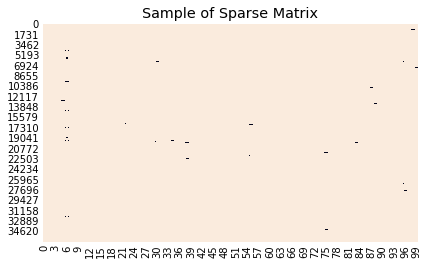

In [ ]:
# Plot sparse matrix for Tf-Idf
# X_train has a shape of (36337 docs, 10000 words)
# Random sample of words from the feature matrix, non-zero values in black
np.random.seed(42)
sns.heatmap(
    X_train_pre.todense()[:,np.random.randint(0, X_train_pre.shape[1], 100)]==0, 
    vmin=0, 
    vmax=1, 
    cbar=False
    ).set_title('Sample of Sparse Matrix');

In [ ]:
# Use feature selection to reduce the matrix dimensionality
# Perform Chi-Square test, check if feature and target are independent

y_train = df_train_balanced['label']
X_features = tfidf_vec_pre.get_feature_names()
p_val_lim = 0.05

chi2, p = feature_selection.chi2(
    X_train_pre, 
    y_train.values.reshape(y_train.shape[0], -1)
    )

tfidf_features = pd.DataFrame({
    'feature': X_features,
    'score': p
    })

tfidf_features = tfidf_features[tfidf_features['score'] <= p_val_lim]

X_features = tfidf_features['feature'].unique().tolist()

In [ ]:
# Fit new Tf-Idf vectorizer on smaller corpus
tfidf_vec_final = feature_extraction.text.TfidfVectorizer(vocabulary=X_features)

tfidf_vec_final.fit(tweet_corpus)
X_train_final = tfidf_vec_final.transform(tweet_corpus)
tfidf_vocab_final = tfidf_vec_final.vocabulary_

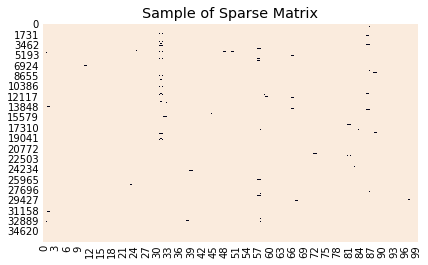

In [ ]:
# Plot sparse matrix for Tf-Idf
# X_train has a shape of (36337 docs, 1911 words)
# Random sample of words from the feature matrix, non-zero values in black
np.random.seed(42)
sns.heatmap(
    X_train_final.todense()[:, 
                            np.random.randint(0, X_train_final.shape[1], 100)
                            ]==0, 
    vmin=0, 
    vmax=1, 
    cbar=False
    ).set_title('Sample of Sparse Matrix');

In [ ]:
# Build Naive Bayes model
clf_nb = naive_bayes.MultinomialNB()

model_nb = pipeline.Pipeline(
    [('vec', tfidf_vec_final),
     ('clf', clf_nb)
     ])

model_nb['clf'].fit(X_train_final, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# Save the bag-of-words naive bayes model for prediction
SAVE_PATH = '../models/'

# Set save directory for transformer unigram
os.chdir(SAVE_PATH)
#model_name = "vectorizer_tfidf_final.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(model_nb['vec'], file)

# Set save directory for transformer unigram
os.chdir(SAVE_PATH)
#model_name = "model_bow_nb_final.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(model_nb['clf'], file)

Accuracy: 0.81
ROC-AUC: 0.81
Detail:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       100
           1       0.75      0.94      0.83       100

    accuracy                           0.81       200
   macro avg       0.83      0.81      0.81       200
weighted avg       0.83      0.81      0.81       200



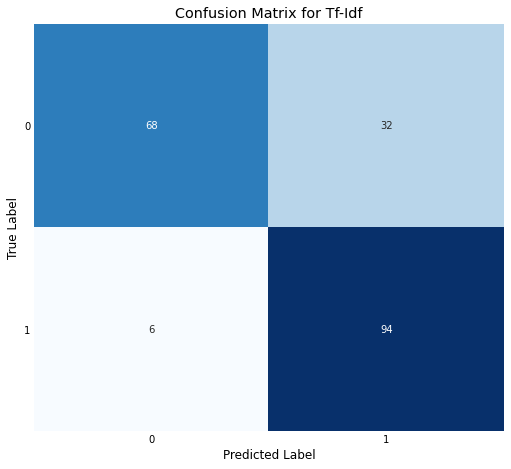

In [ ]:
# Evaluate performance of bag-of-words model

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

y_dev = df_dev['label'].values
X_dev = df_dev['tweet_clean'].values
preds_bow = model_nb.predict(X_dev)
preds_prob_bow = model_nb.predict_proba(X_dev)

classes = np.unique(y_dev)
y_dev_array = pd.get_dummies(y_dev, drop_first=False).values

# Print Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_dev, preds_bow)
auc = metrics.roc_auc_score(y_dev, preds_bow)
print("Accuracy:",  round(accuracy,2))
print("ROC-AUC:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_dev, preds_bow))
    
# Plot confusion matrix
cm = metrics.confusion_matrix(y_dev, preds_bow)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted Label", ylabel="True Label", xticklabels=classes, 
       yticklabels=classes, title="Confusion Matrix for Tf-Idf")
plt.yticks(rotation=0)

plt.show(); ## accuracy of 81% for dev dataset

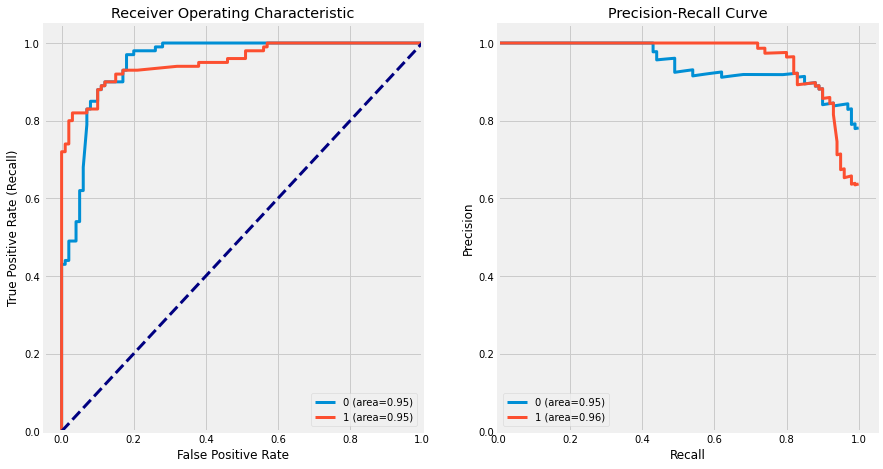

In [ ]:
# Evaluate performance of bag-of-words model

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

# Plot ROC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.3, 7.5))
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_dev_array[:,i],  
                           preds_prob_bow[:,i])
    ax[0].plot(fpr, tpr, lw=3,
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_dev_array[:,i], preds_prob_bow[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall Curve")
ax[1].legend(loc="best")
ax[1].grid(True)

plt.savefig('../assets/fig-bow-roc-precision-recall-final.png', 
            bbox_inches='tight'
            )

plt.show();

### Word Embedding 

Words of the same context usually appear together in the same corpus, meaning the words will be close in the vector space as well. 
<br><br>
We will apply a set of feature engineering techniques to map words from the vocabulary to vectors of real numbers. In particular, we will use Google’s Word2Vec (2013), but other Word Embedding models include Stanford’s GloVe (2014) and Facebook’s FastText (2016).

In [ ]:
# Reload spaCy model for lemmatization
nlp_spacy = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])
nlp_spacy.add_pipe(nlp_spacy.create_pipe('sentencizer'))

# Get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp_spacy.Defaults.token_match)

# Add desired pattern for hashtags and in-word hyphens
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# Overwrite token_match function of the tokenizer
nlp_spacy.tokenizer.token_match = re.compile(re_token_match).match

In [ ]:
# Apply pipeline workflow for spaCy 

# Code adapated from Prashanth Rao
# >>> https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-3:-Parallelize-the-work-using-joblib

def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stops] 
    return lemma_list

def preprocess_pipe_ug(texts):
    preproc_pipe = []
    for doc in nlp_spacy.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

# Apply spaCy lemmas
X_train_w2v_ug = preprocess_pipe_ug(df_train_balanced.tweet_clean)

In [ ]:
# Save the unigram transformer for prediction
SAVE_PATH = '../models/'

# Set save directory for transformer unigram
os.chdir(SAVE_PATH)
#model_name = "X_train_w2v_ug.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(X_train_w2v_ug, file)

In [ ]:
# Create list of unigrams, bigrams, trigrams
# Make list of unigrams
sentence_stream = X_train_w2v_ug

# Make list of bigrams
bigram = Phrases(sentence_stream,
                 min_count=5, 
                 threshold=10, 
                 delimiter=' '.encode()
                 )
bigram_phraser = Phraser(bigram)
X_train_w2v_bg = bigram_phraser[sentence_stream]

# Make list of trigrams
trigram = Phrases(X_train_w2v_bg, 
                  min_count=5, 
                  threshold=10, 
                  delimiter=' '.encode()
                  )
trigram_phraser = Phraser(trigram)
X_train_w2v_tg = trigram_phraser[X_train_w2v_bg]

In [ ]:
# Save the bigram and trigram detectors
SAVE_PATH = '../models/'

# Set save directory for transformer bigram
os.chdir(SAVE_PATH)
#model_name = "detector_bigram.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(bigram_phraser, file)

# Set save directory for transformer trigram
os.chdir(SAVE_PATH)
#model_name = "detector_trigram.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(trigram_phraser, file)

In [ ]:
# Check word embedding with Word2Vec model
# Combination of continuous bag of words and skip grams
nlp_gen = gensim.models.word2vec.Word2Vec(
    X_train_w2v_tg, 
    size=300, ## desired number of features / independent variables
    window=8, ## mean length of text in corpus, distance between words
    min_count=1, ## ignore words with total frequency less than 1
    sg=1, ## skip gram model
    iter=30, ## number of iterations (epochs) over the corpus
    seed=42)

In [ ]:
# Save the bigram and trigram detectors
SAVE_PATH = '../models/'

# Set save directory for transformer trigram
os.chdir(SAVE_PATH)
model_name = "model_word2vec.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(nlp_gen, file)

In [ ]:
# Transform train corpus into list of sequences with tensorflow/keras
# Make tokens
k_token = Tokenizer(lower=True, 
                    split=' ',
                    oov_token="NaN",
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
                    )
k_token.fit_on_texts(X_train_w2v_tg)
k_dict_vocab = k_token.word_index

# Create sequence
lst_txt2seq_train = k_token.texts_to_sequences(X_train_w2v_tg)

# Pad sequence
X_train_pad = pad_sequences(
    lst_txt2seq_train,
    maxlen=15,
    padding="post",
    truncating="post"
    )

In [ ]:
# Save the keras tokenizer
SAVE_PATH = '../models/'

# Set save directory for keras tokenizer
os.chdir(SAVE_PATH)
#model_name = "token_keras.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(k_token, file)

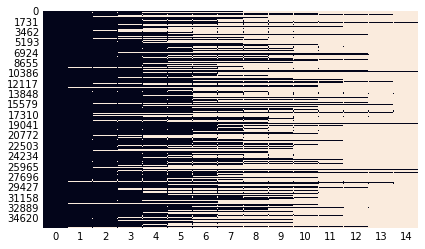

In [ ]:
# Plot feature matrix
# X_train_pad has a shape of (36337 sequences, 15 sequences max length)
sns.heatmap(X_train_pad==0, vmin=0, vmax=1, cbar=False)
plt.show(); # each text is id sequence with length of 15

In [ ]:
# Transform dev corpus into list of sequences with tensorflow/keras
# Apply spaCy lemmas
X_dev_w2v_ug = preprocess_pipe_ug(df_dev.tweet_clean)

# Detect common bigrams and trigrams
X_dev_w2v_bg = list(bigram_phraser[X_dev_w2v_ug])
X_dev_w2v_tg = list(trigram_phraser[X_dev_w2v_bg])

# Create sequence
lst_txt2seq_dev = k_token.texts_to_sequences(X_dev_w2v_tg)

# Pad sequence
X_dev_pad = pad_sequences(
    lst_txt2seq_dev,
    maxlen=15,
    padding="post",
    truncating="post"
    )

In [ ]:
# Save the trigram transformer for prediction
SAVE_PATH = '../models/'

# Set save directory for transformer dev trigram
os.chdir(SAVE_PATH)
#model_name = "X_dev_w2v_tg.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(X_dev_w2v_tg, file)

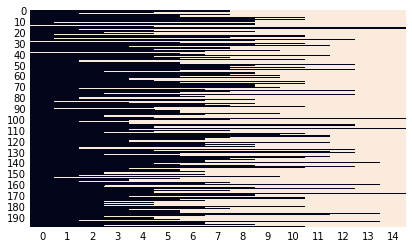

In [ ]:
# Plot feature matrix
# X_dev_pad has a shape of (200 sequences, 15 sequences max length)
sns.heatmap(X_dev_pad==0, vmin=0, vmax=1, cbar=False)
plt.show(); # each text is id sequence with length of 15

In [ ]:
# Create matrix for embedding to weight matrix in neural network
# Start the matrix (len of vocab by vector size)
word_embed = np.zeros((len(k_dict_vocab) + 1, 300))

for word,idx in k_dict_vocab.items():
    # Update the row with vector
    try:
        word_embed[idx] =  nlp[word]
    # If word not in model then skip and the row stays all 0s
    except:
        pass

# matrix of shape 19236 len of vocab, 300 vector size

In [ ]:
# Build deep learning model

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

# Use embedding matrix in the first Embedding layer of the neural network
# Output of Embedding layer is a 2D matrix with word vector for each word id
# Add simple Attention layer to capture weights for explainability
# Use two layers of Bidirectional LSTM to model order of words
# Use two final dense layers to predict the probability of each category

# Code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

# Add input
x_in = layers.Input(shape=(15,)) ## embedding
x = layers.Embedding(input_dim=word_embed.shape[0],  
                     output_dim=word_embed.shape[1], 
                     weights=[word_embed],
                     input_length=15, trainable=False)(x_in) ## apply attention
x = attention_layer(x, neurons=15) ## two layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x) ## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x) ## compile

model_we = models.Model(x_in, y_out)
model_we.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model_we.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      5797800     input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 300, 15)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300, 15)      240         permute_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Train deep learning model
# Encode y
y_train = df_train_balanced['label'].values

dict_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dict_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

# Train the model
training = model_we.fit(x=X_train_pad, 
                        y=y_train, 
                        batch_size=256, 
                        epochs=10, 
                        shuffle=True, 
                        verbose=0, 
                        validation_split=0.3)

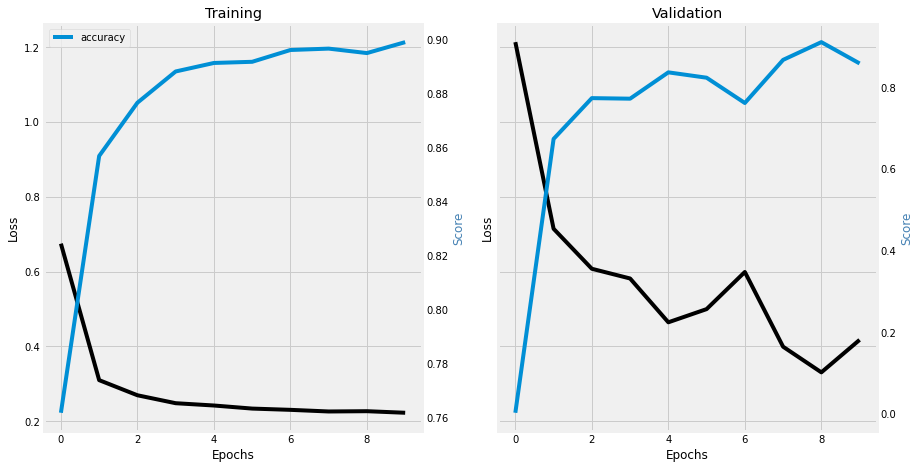

In [ ]:
# Plot loss and accuracy from deep learning training

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

metrics_dpl = [k for k in training.history.keys() 
    if ("loss" not in k) and ("val" not in k)]

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13.3, 7.5))
 
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')

for m in metrics_dpl:
    ax11.plot(training.history[m], label=m)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax11.grid(False)

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')

for m in metrics_dpl:
     ax22.plot(training.history['val_'+m], label=m)
ax22.set_ylabel("Score", color="steelblue")
ax22.grid(False)

plt.savefig('../assets/fig-we-lstm-train-val.png', bbox_inches='tight')
plt.show(); # accuracy over 90% in some epochs

In [ ]:
# Install libary to save keras model
! pip install h5py --quiet

In [ ]:
# Save the word embedding model for prediction
SAVE_PATH = '../models/'

# Serialize word embedding model to JSON
os.chdir(SAVE_PATH)
model_json = model_we.to_json()
with open("model_wordembed_main.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model_we.save_weights("model_wordembed_weights.h5")

Accuracy: 0.88
ROC-AUC: 0.88
Detail:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       100
           1       0.85      0.93      0.89       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



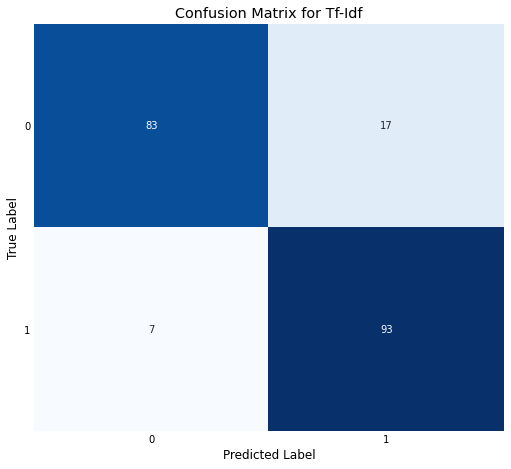

In [ ]:
# Evaluate performance of word embedding model

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

y_dev = df_dev['label'].values
pred_prob_we = model_we.predict(X_dev_pad)
preds_we =[dict_y_mapping[np.argmax(pred)] for pred in pred_prob_we]

classes = np.unique(y_dev)
y_dev_array = pd.get_dummies(y_dev, drop_first=False).values

# Print Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_dev, preds_we)
auc = metrics.roc_auc_score(y_dev, preds_we)
print("Accuracy:",  round(accuracy,2))
print("ROC-AUC:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_dev, preds_we))
    
# Plot confusion matrix
cm = metrics.confusion_matrix(y_dev, preds_we)
fig, ax = plt.subplots(figsize=(7.5,7.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted Label", ylabel="True Label", xticklabels=classes, 
       yticklabels=classes, title="Confusion Matrix for Tf-Idf")
plt.yticks(rotation=0)
plt.show(); # accuracy of 88% on dev dataset

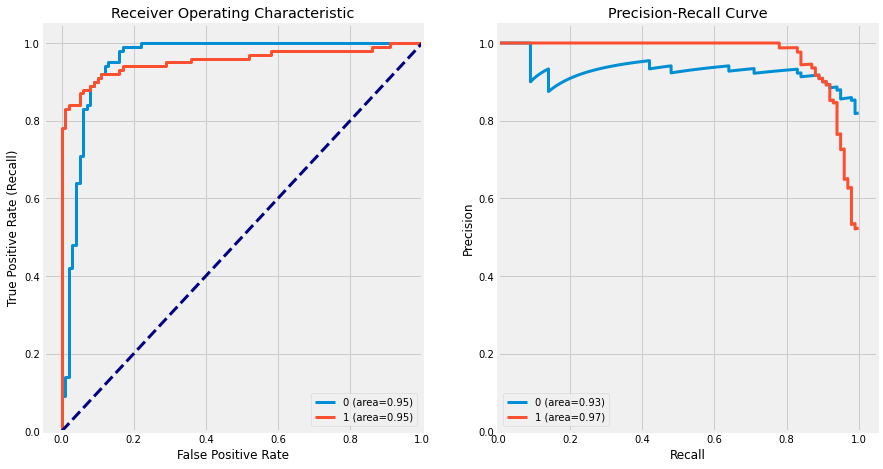

In [ ]:
# Evaluate performance of bag-of-words model

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

# Plot ROC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.3, 7.5))
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_dev_array[:,i],  
                           pred_prob_we[:,i])
    ax[0].plot(fpr, tpr, lw=3,
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_dev_array[:,i], pred_prob_we[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall Curve")
ax[1].legend(loc="best")
ax[1].grid(True)

plt.savefig('../assets/fig-wordembed-roc-precision-recall-final.png', bbox_inches='tight')
plt.show();